# Correlation along sensorimotor-transmodal axis

In [1]:
import os
from pathlib import Path
import matplotlib.pyplot as plt
root_dir = Path("/tscc/projects/ps-epigen/users/biy022/biccn/data/SNAREdata/scenicplus/")
os.chdir(root_dir / "L4_IT")
plot_dir = Path("/tscc/projects/ps-epigen/users/biy022/biccn/analysis/scenicplus/L4_IT/figures/")

In [2]:
import pandas as pd
pd.options.mode.chained_assignment = None 
import scanpy as sc
import decoupler as dc
import numpy as np
import scipy.stats as stats
import seaborn as sns

## RNA (donor as replicate, |corr| > 0.7, padjusted < 0.01, expr filtered)

In [3]:
L4_IT_rna = sc.read_h5ad("L4_IT_rna_matrix.h5ad")
L4_IT_rna_counts = L4_IT_rna.raw.to_adata()

In [4]:
L4_IT_rna_counts.obs["Donor_Region"] = \
    L4_IT_rna_counts.obs["PatientID"].astype("str") + "_" + L4_IT_rna_counts.obs["Region"].astype("str")

In [5]:
L4_IT_rna_region_counts = dc.get_pseudobulk(
    adata=L4_IT_rna_counts,
    sample_col="Donor_Region",
    groups_col=None,
    min_cells=0,
    min_counts=0,
    remove_empty=True,
    mode="sum"
)
kept_genes = dc.filter_by_expr(
    L4_IT_rna_region_counts,
    group="Region",
    min_count=10,
    min_total_count=15
)
sc.pp.normalize_total(L4_IT_rna_region_counts, target_sum=1e6)
sc.pp.log1p(L4_IT_rna_region_counts, base=2)
L4_IT_rna_region_counts_filtered = L4_IT_rna_region_counts[:, kept_genes].copy()

In [6]:
region_align = ["A24", "A9", "FI", "MTG", "AnG", "M1C", "S1C", "A1C", "V1C"]
L4_IT_rna_region_counts_filtered.obs["Region"] = pd.Categorical(
    L4_IT_rna_region_counts_filtered.obs["Region"], categories=region_align
)
sorted_index = L4_IT_rna_region_counts_filtered.obs.sort_values(by="Region").index

In [7]:
b = L4_IT_rna_region_counts_filtered.obs.loc[sorted_index, "Region"].cat.codes.to_list()
data_matrix = L4_IT_rna_region_counts_filtered[sorted_index, :].X
corrs = np.zeros(data_matrix.shape[1])
pvalues = np.zeros(data_matrix.shape[1])

for i in range(0, data_matrix.shape[1]):
    a = data_matrix[:, i]
    corr, pvalue = stats.spearmanr(a, b)
    corrs[i] = corr
    pvalues[i] = pvalue
padjusted = stats.false_discovery_control(pvalues, method="bh")
spearman_result = pd.DataFrame({
    "gene": L4_IT_rna_region_counts_filtered.var.index.to_list(),
    "corr": corrs,
    "p_value": pvalues,
    "p_adjusted": padjusted,
})
spearman_result.to_csv(
    "L4_IT_ST_spearman_corr_with_donor_replicates_expr_filtered.tsv", sep="\t", header=True, index=False)

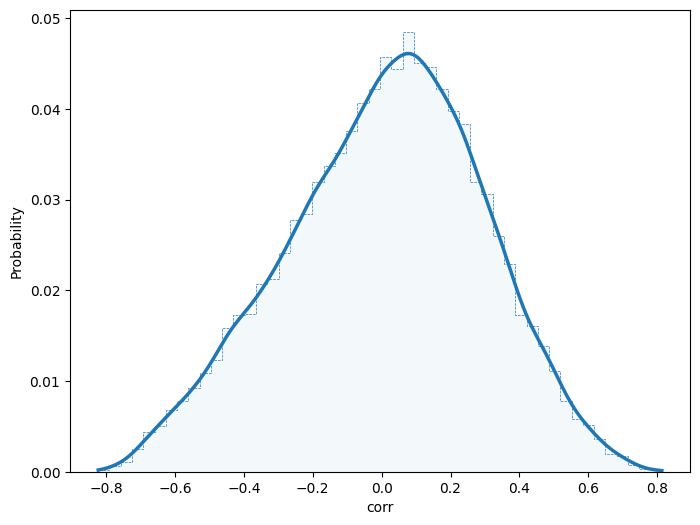

In [8]:
fig, ax = plt.subplots(1, 1)
fig.set_figwidth(8)
fig.set_figheight(6)
sns.histplot(
    spearman_result, 
    x="corr",  
    stat="probability", 
    fill=True,
    alpha=0.05,
    element="step",
    linewidth=0.5,
    linestyle="dashed",
    bins=50,
    kde=True,
    line_kws={"linewidth": 2.5},
    cbar_kws={"loc": "right"}
)
fig.savefig(plot_dir / "ST_L4_IT_corr_distribution.png", format="png", dpi=300)

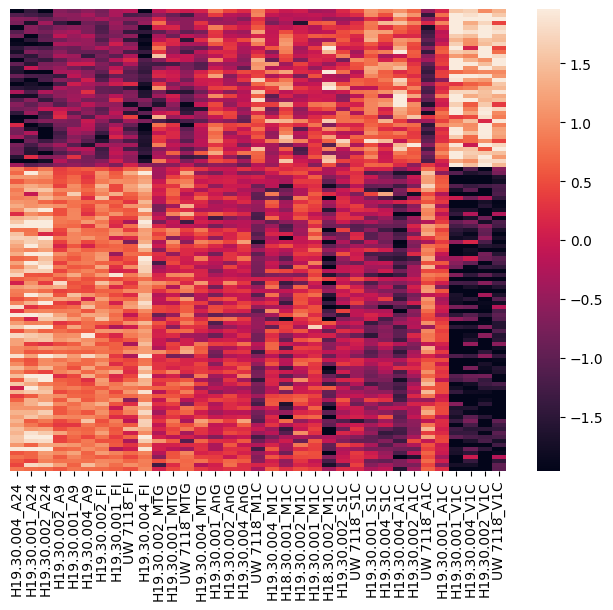

In [9]:
selected_genes = spearman_result[
    (spearman_result["p_adjusted"] < 0.01) &
    (np.abs(spearman_result["corr"]) > 0.7)
]["gene"].to_list()
selected_df = spearman_result[spearman_result["gene"].isin(selected_genes)]
selected_df_sorted = selected_df.sort_values("corr", ascending=False)
plot_matrix = L4_IT_rna_region_counts_filtered[sorted_index, selected_df_sorted["gene"].to_list()].X.T
row_means = np.mean(plot_matrix, axis=1, keepdims=True)
row_stds = np.std(plot_matrix, axis=1, keepdims=True)
plot_matrix_z = (plot_matrix - row_means) / row_stds

fig, ax = plt.subplots(1, 1)
fig.set_figwidth(8)
fig.set_figheight(6)
sns.heatmap(
    plot_matrix_z,
    vmin=-1.96,
    vmax=1.96,
    xticklabels=sorted_index,
    yticklabels=[],
    ax=ax
)
fig.savefig(plot_dir / "ST_L4_IT_RC_corr_genes_heatmap.png", format="png", dpi=300)

In [10]:
positive_corr_genes = spearman_result[
    (spearman_result["corr"] > 0.7) &
    (spearman_result["p_adjusted"] < 0.01)
]["gene"].to_list()
with open("sensorimotor_transmodel_spearman/positive_corr_7e-1_bh_1e-2_donor.tsv", "w") as fout:
    for gene in positive_corr_genes:
        fout.write("{}\n".format(gene))

In [11]:
negative_corr_genes = spearman_result[
    (spearman_result["corr"] < -0.7) &
    (spearman_result["p_adjusted"] < 0.01)
]["gene"].to_list()
with open("sensorimotor_transmodel_spearman/negative_corr_7e-1_bh_1e-2_donor.tsv", "w") as fout:
    for gene in negative_corr_genes:
        fout.write("{}\n".format(gene))

In [12]:
with open("sensorimotor_transmodel_spearman/full_gene_list.tsv", "w") as fout:
    for gene in spearman_result["gene"].to_list():
        fout.write("{}\n".format(gene))

## ATAC (donor as replicate, |corr| > 0.5, padjusted < 0.05, expr filtered)

In [3]:
L4_IT_atac_counts = sc.read_h5ad("L4_IT_atac_matrix.h5ad")

In [4]:
L4_IT_atac_counts.obs["Donor_Region"] = \
    L4_IT_atac_counts.obs["PatientID"].astype("str") + "_" + L4_IT_atac_counts.obs["Region"].astype("str")

In [5]:
L4_IT_atac_region_counts = dc.get_pseudobulk(
    adata=L4_IT_atac_counts,
    sample_col="Donor_Region",
    groups_col=None,
    min_cells=0,
    min_counts=0,
    remove_empty=True,
    mode="sum"
)
kept_regions = dc.filter_by_expr(
    L4_IT_atac_region_counts,
    group="Region",
    min_count=5,
    min_total_count=15
)
sc.pp.normalize_total(L4_IT_atac_region_counts, target_sum=1e6)
sc.pp.log1p(L4_IT_atac_region_counts, base=2)
L4_IT_atac_region_counts_filtered = L4_IT_atac_region_counts[:, kept_regions].copy()

In [6]:
region_align = ["A24", "A9", "FI", "MTG", "AnG", "M1C", "S1C", "A1C", "V1C"]
L4_IT_atac_region_counts_filtered.obs["Region"] = pd.Categorical(
    L4_IT_atac_region_counts_filtered.obs["Region"], categories=region_align
)
sorted_index = L4_IT_atac_region_counts_filtered.obs.sort_values(by="Region").index

In [7]:
b = L4_IT_atac_region_counts_filtered.obs.loc[sorted_index, "Region"].cat.codes.to_list()
data_matrix = L4_IT_atac_region_counts_filtered[sorted_index, :].X
corrs = np.zeros(data_matrix.shape[1])
pvalues = np.zeros(data_matrix.shape[1])

for i in range(0, data_matrix.shape[1]):
    a = data_matrix[:, i]
    corr, pvalue = stats.spearmanr(a, b)
    corrs[i] = corr
    pvalues[i] = pvalue
padjusted = stats.false_discovery_control(pvalues, method="bh")
spearman_result = pd.DataFrame({
    "region": L4_IT_atac_region_counts_filtered.var.index.to_list(),
    "corr": corrs,
    "p_value": pvalues,
    "p_adjusted": padjusted,
})
spearman_result.to_csv(
    "L4_IT_atac_ST_spearman_corr_with_donor_replicates_expr_filtered.tsv", sep="\t", header=True, index=False)

<AxesSubplot: xlabel='corr', ylabel='Probability'>

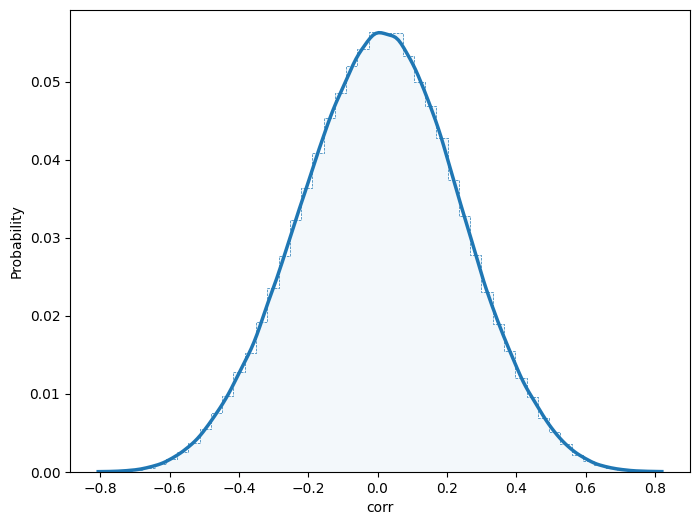

In [8]:
fig, ax = plt.subplots(1, 1)
fig.set_figwidth(8)
fig.set_figheight(6)
sns.histplot(
    spearman_result, 
    x="corr",  
    stat="probability", 
    fill=True,
    alpha=0.05,
    element="step",
    linewidth=0.5,
    linestyle="dashed",
    bins=50,
    kde=True,
    line_kws={"linewidth": 2.5},
    cbar_kws={"loc": "right"}
)
# fig.savefig(plot_dir / "L4_IT_RC_corr_atac_distribution.png", format="png", dpi=300)

<AxesSubplot: >

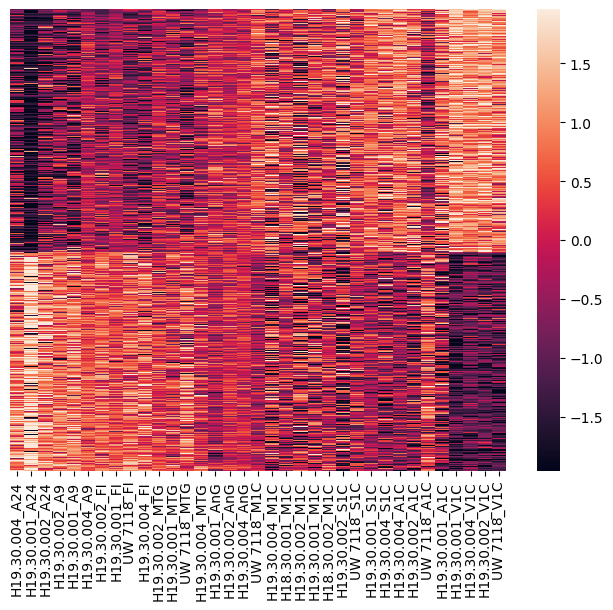

In [9]:
selected_regions = spearman_result[
    (spearman_result["p_adjusted"] < 0.05) &
    (np.abs(spearman_result["corr"]) > 0.5)
]["region"].to_list()
selected_df = spearman_result[spearman_result["region"].isin(selected_regions)]
selected_df_sorted = selected_df.sort_values("corr", ascending=False)
plot_matrix = L4_IT_atac_region_counts_filtered[sorted_index, selected_df_sorted["region"].to_list()].X.T
row_means = np.mean(plot_matrix, axis=1, keepdims=True)
row_stds = np.std(plot_matrix, axis=1, keepdims=True)
plot_matrix_z = (plot_matrix - row_means) / row_stds

fig, ax = plt.subplots(1, 1)
fig.set_figwidth(8)
fig.set_figheight(6)
sns.heatmap(
    plot_matrix_z,
    vmin=-1.96,
    vmax=1.96,
    xticklabels=sorted_index,
    yticklabels=[],
    ax=ax
)
# fig.savefig(plot_dir / "L4_IT_RC_corr_atac_heatmap.png", format="png", dpi=300)

In [10]:
positive_corr_regions = spearman_result[
    (spearman_result["corr"] > 0.5) &
    (spearman_result["p_adjusted"] < 0.05)
]["region"].to_list()
with open("sensorimotor_transmodel_spearman_expr_filtered/positive_atac_corr_5e-1_bh_5e-2_donor.tsv", "w") as fout:
    for region in positive_corr_regions:
        fout.write("{}\n".format(region))

In [11]:
negative_corr_regions = spearman_result[
    (spearman_result["corr"] < -0.5) &
    (spearman_result["p_adjusted"] < 0.05)
]["region"].to_list()
with open("sensorimotor_transmodel_spearman_expr_filtered//negative_atac_corr_5e-1_bh_5e-2_donor.tsv", "w") as fout:
    for region in negative_corr_regions:
        fout.write("{}\n".format(region))